In [76]:
# Utilities

In [77]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
from scipy.stats import gaussian_kde

import datetime
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import multiprocessing as mp
import json
import xarray as xr
# from dask import delayed
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')
import itertools

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

In [78]:
indices = ['strn26','strn35','index']

In [79]:
ds = xr.open_dataset('CMIP6_amoc.nc')

strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index

yrs = strn26.year.values
models = strn26.models.values
ensembs = strn26.ensemble_members.values

In [80]:
def kde_plot(ax,xs,data,col='C0',lbl='',linestyle='-',norm=False):
    data = data[~np.isnan(data)]
    if data.sum()==0:
        ax.plot(xs,np.full_like(xs,0))
    else:
        density = gaussian_kde(data)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ys = density(xs)
        if norm:
            ax.plot(xs,ys/ys.mean(),color=col,label=lbl,lw=2,linestyle=linestyle)
        else:
            ax.plot(xs,ys,color=col,label=lbl,lw=2,linestyle=linestyle)

In [81]:
# EWS

In [82]:
ds=xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_metrics.nc')
surr_taus = ds.taus
surr_ps = ds.ps

In [83]:
amoc = xr.open_dataset('CMIP6_amoc2.nc').amoc

In [84]:
cmip_taus = xr.open_dataset('new_EWS/CMIP6_lam_tau_w50.nc').taus
cmip_ps = xr.open_dataset('new_EWS/CMIP6_lam_pvs_w50.nc').trends
cmip_lams =  xr.open_dataset('new_EWS/CMIP6_lam_pvs_w50.nc').lambdas

In [85]:
amoc = xr.open_dataset('CMIP6_amoc2.nc').amoc

In [86]:
d = cmip_ps.expand_dims(dim='surrogates', axis=0)
parr = xr.concat((surr_ps,d),dim='surrogates') # the last value on the row is the cmip6 one

d = cmip_taus.expand_dims(dim='surrogates', axis=0)
tarr = xr.concat((surr_taus,d),dim='surrogates') # the last value on the row is the cmip6 one

In [87]:
def f(x):
    if not np.isnan(x[-1]):
        x=x[~np.isnan(x)]
        return st.percentileofscore(x, x[-1])
    else:
        return np.nan

ppvs = 1- np.apply_along_axis(f, 0, parr)/100
tpvs = 1- np.apply_along_axis(f, 0, tarr)/100

In [88]:
sppvs = []
stpvs = []
for i in range(10):
    def f2(x):
        if not np.isnan(x[i]):
            x=x[~np.isnan(x)]
            return st.percentileofscore(x, x[i])
        else:
            return np.nan
    sppvs1 = 1- np.apply_along_axis(f2, 0, surr_ps)/100
    stpvs1 = 1- np.apply_along_axis(f2, 0, surr_taus)/100
    sppvs.append(sppvs1)
    stpvs.append(stpvs1)
# def f2(x):
#     return st.percentileofscore(x, x[1])

# sppvs2 = 1- np.apply_along_axis(f2, 0, surr_ps)/100
# stpvs2 = 1- np.apply_along_axis(f2, 0, surr_taus)/100

# def f2(x):
#     return st.percentileofscore(x, x[100])

# sppvs3 = 1- np.apply_along_axis(f2, 0, surr_ps)/100
# stpvs3 = 1- np.apply_along_axis(f2, 0, surr_taus)/100

In [89]:
ss = []
sts = []
for i, sppv in enumerate(sppvs):
    ss.append(len(np.where(sppv<=0.05)[0]))
    sts.append(len(np.where(stpvs[i]<=0.05)[0]))

In [90]:
idc = np.where((ppvs<=0.05) & (tpvs<=0.05))
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th ensemble member'.format(models[idc[1][i]],indices[idx],idc[2][i]))

INM-CM5-0 - strn26 - 0th ensemble member
MIROC6 - strn26 - 1th ensemble member
UKESM1-0-LL - strn26 - 9th ensemble member
MRI-ESM2-0 - strn26 - 0th ensemble member
CESM2 - strn26 - 5th ensemble member
CESM2 - strn26 - 7th ensemble member
NorESM2-LM - strn26 - 2th ensemble member
NESM3 - strn26 - 3th ensemble member
CanESM5 - strn35 - 6th ensemble member
FIO-ESM-2-0 - strn35 - 0th ensemble member
MIROC6 - strn35 - 4th ensemble member
MIROC6 - strn35 - 5th ensemble member
MIROC6 - strn35 - 7th ensemble member
UKESM1-0-LL - strn35 - 4th ensemble member
UKESM1-0-LL - strn35 - 7th ensemble member
MPI-ESM1-2-HR - strn35 - 8th ensemble member
CESM2 - strn35 - 2th ensemble member
CESM2 - strn35 - 3th ensemble member
CESM2 - strn35 - 7th ensemble member
CESM2-WACCM - strn35 - 0th ensemble member
CanESM5 - index - 4th ensemble member
CanESM5 - index - 9th ensemble member
INM-CM5-0 - index - 4th ensemble member
MIROC6 - index - 2th ensemble member


In [91]:
idc = np.where(sppvs[0]<=0.05)
print(len(idc[0]))
idc = np.where(ppvs<=0.05)
print(len(idc[0]))

idc = np.where(stpvs[0]<=0.05)
print(len(idc[0]))
idc = np.where(tpvs<=0.05)
print(len(idc[0]))

17
42
13
33


In [92]:
idc = np.where(ppvs<=0.05)
for i, idx in enumerate(idc[0]):
    print('{} - {} - {}th'.format(models[idc[1][i]],indices[idx],idc[2][i],ppvs[idx,idc[1][i],idc[2][i]]))

CAMS-CSM1-0 - strn26 - 1th
CanESM5 - strn26 - 6th
CNRM-CM6-1 - strn26 - 7th
INM-CM5-0 - strn26 - 0th
INM-CM5-0 - strn26 - 1th
MIROC6 - strn26 - 1th
MIROC6 - strn26 - 7th
HadGEM3-GC31-LL - strn26 - 2th
UKESM1-0-LL - strn26 - 9th
MPI-ESM1-2-HR - strn26 - 1th
MPI-ESM1-2-HR - strn26 - 6th
MRI-ESM2-0 - strn26 - 0th
CESM2 - strn26 - 0th
CESM2 - strn26 - 1th
CESM2 - strn26 - 5th
CESM2 - strn26 - 7th
NorESM2-LM - strn26 - 2th
NESM3 - strn26 - 3th
CanESM5 - strn35 - 6th
FIO-ESM-2-0 - strn35 - 0th
MIROC6 - strn35 - 4th
MIROC6 - strn35 - 5th
MIROC6 - strn35 - 7th
HadGEM3-GC31-LL - strn35 - 2th
HadGEM3-GC31-MM - strn35 - 0th
HadGEM3-GC31-MM - strn35 - 1th
UKESM1-0-LL - strn35 - 4th
UKESM1-0-LL - strn35 - 7th
MPI-ESM1-2-HR - strn35 - 8th
CESM2 - strn35 - 2th
CESM2 - strn35 - 3th
CESM2 - strn35 - 6th
CESM2 - strn35 - 7th
CESM2-WACCM - strn35 - 0th
CanESM5 - index - 4th
CanESM5 - index - 9th
CNRM-CM6-1 - index - 3th
INM-CM5-0 - index - 4th
MIROC6 - index - 2th
MPI-ESM1-2-HR - index - 5th
MPI-ESM1-2-H

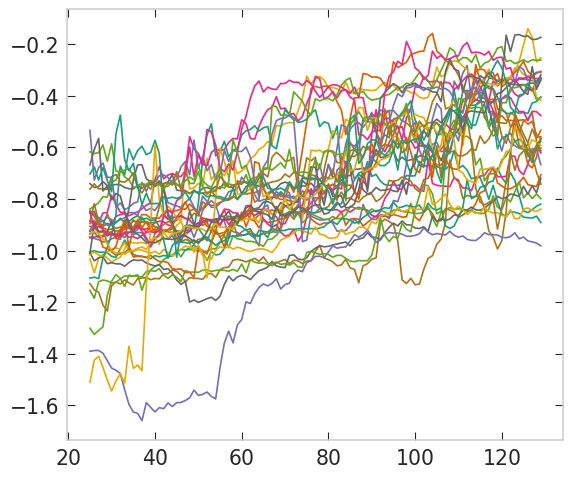

In [93]:
idc = np.where(tpvs<=0.05)
for i,lam in enumerate(cmip_lams.values[idc]):
    plt.plot(lam)

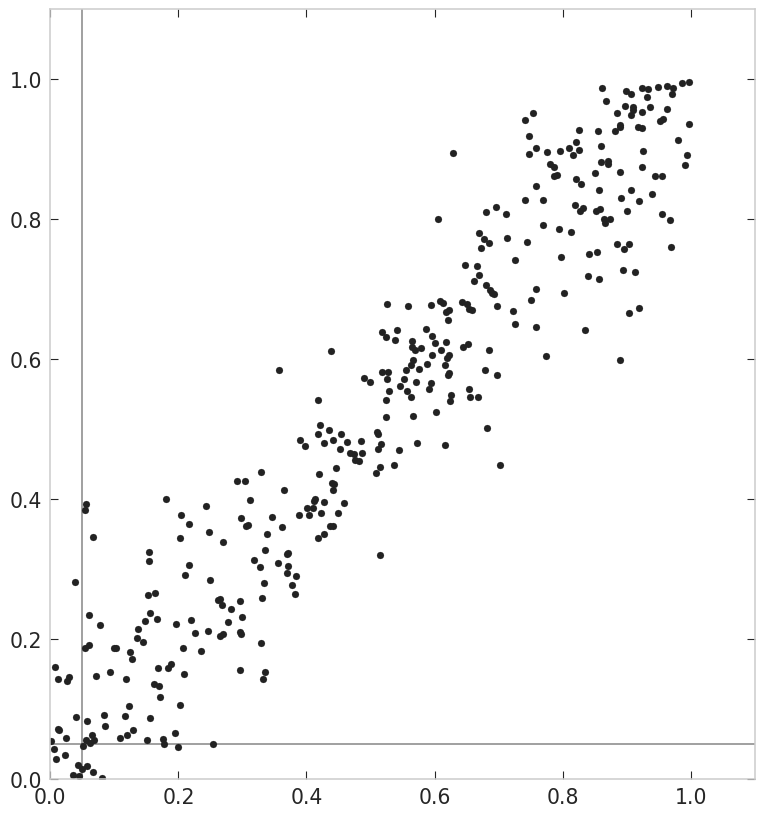

In [94]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
plt.scatter(sppvs[0],stpvs[0],color='k',marker='.',s=100)
ax.hlines(0.05,0,1.1,color='k',alpha=0.5)
ax.vlines(0.05,0,1.1,color='k',alpha=0.5)
ax.set_ylim(0,1.1)
ax.set_xlim(0,1.1)
plt.show()

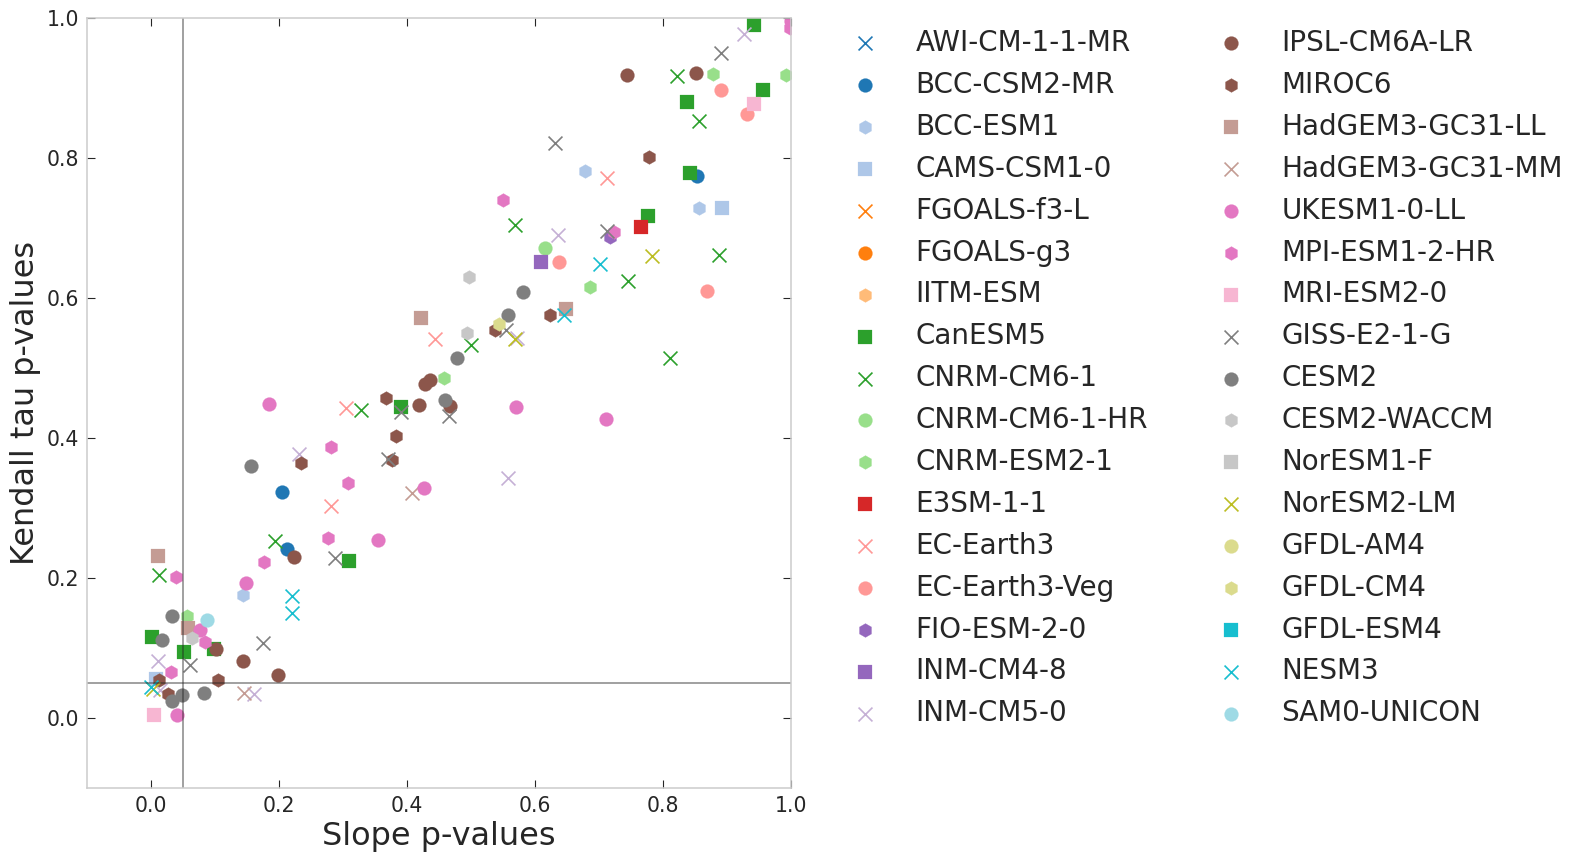

In [95]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(ppvs[0][i],tpvs[0][i],color=col,label=mod,marker=marker,s=100)
ax.hlines(0.05,-0.1,1,color='k',alpha=0.5)
ax.vlines(0.05,-0.1,1,color='k',alpha=0.5)
ax.set_ylim(-0.1,1)
ax.set_xlim(-0.1,1)
ax.set_ylabel('Kendall tau p-values')
ax.set_xlabel('Slope p-values')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
plt.show()

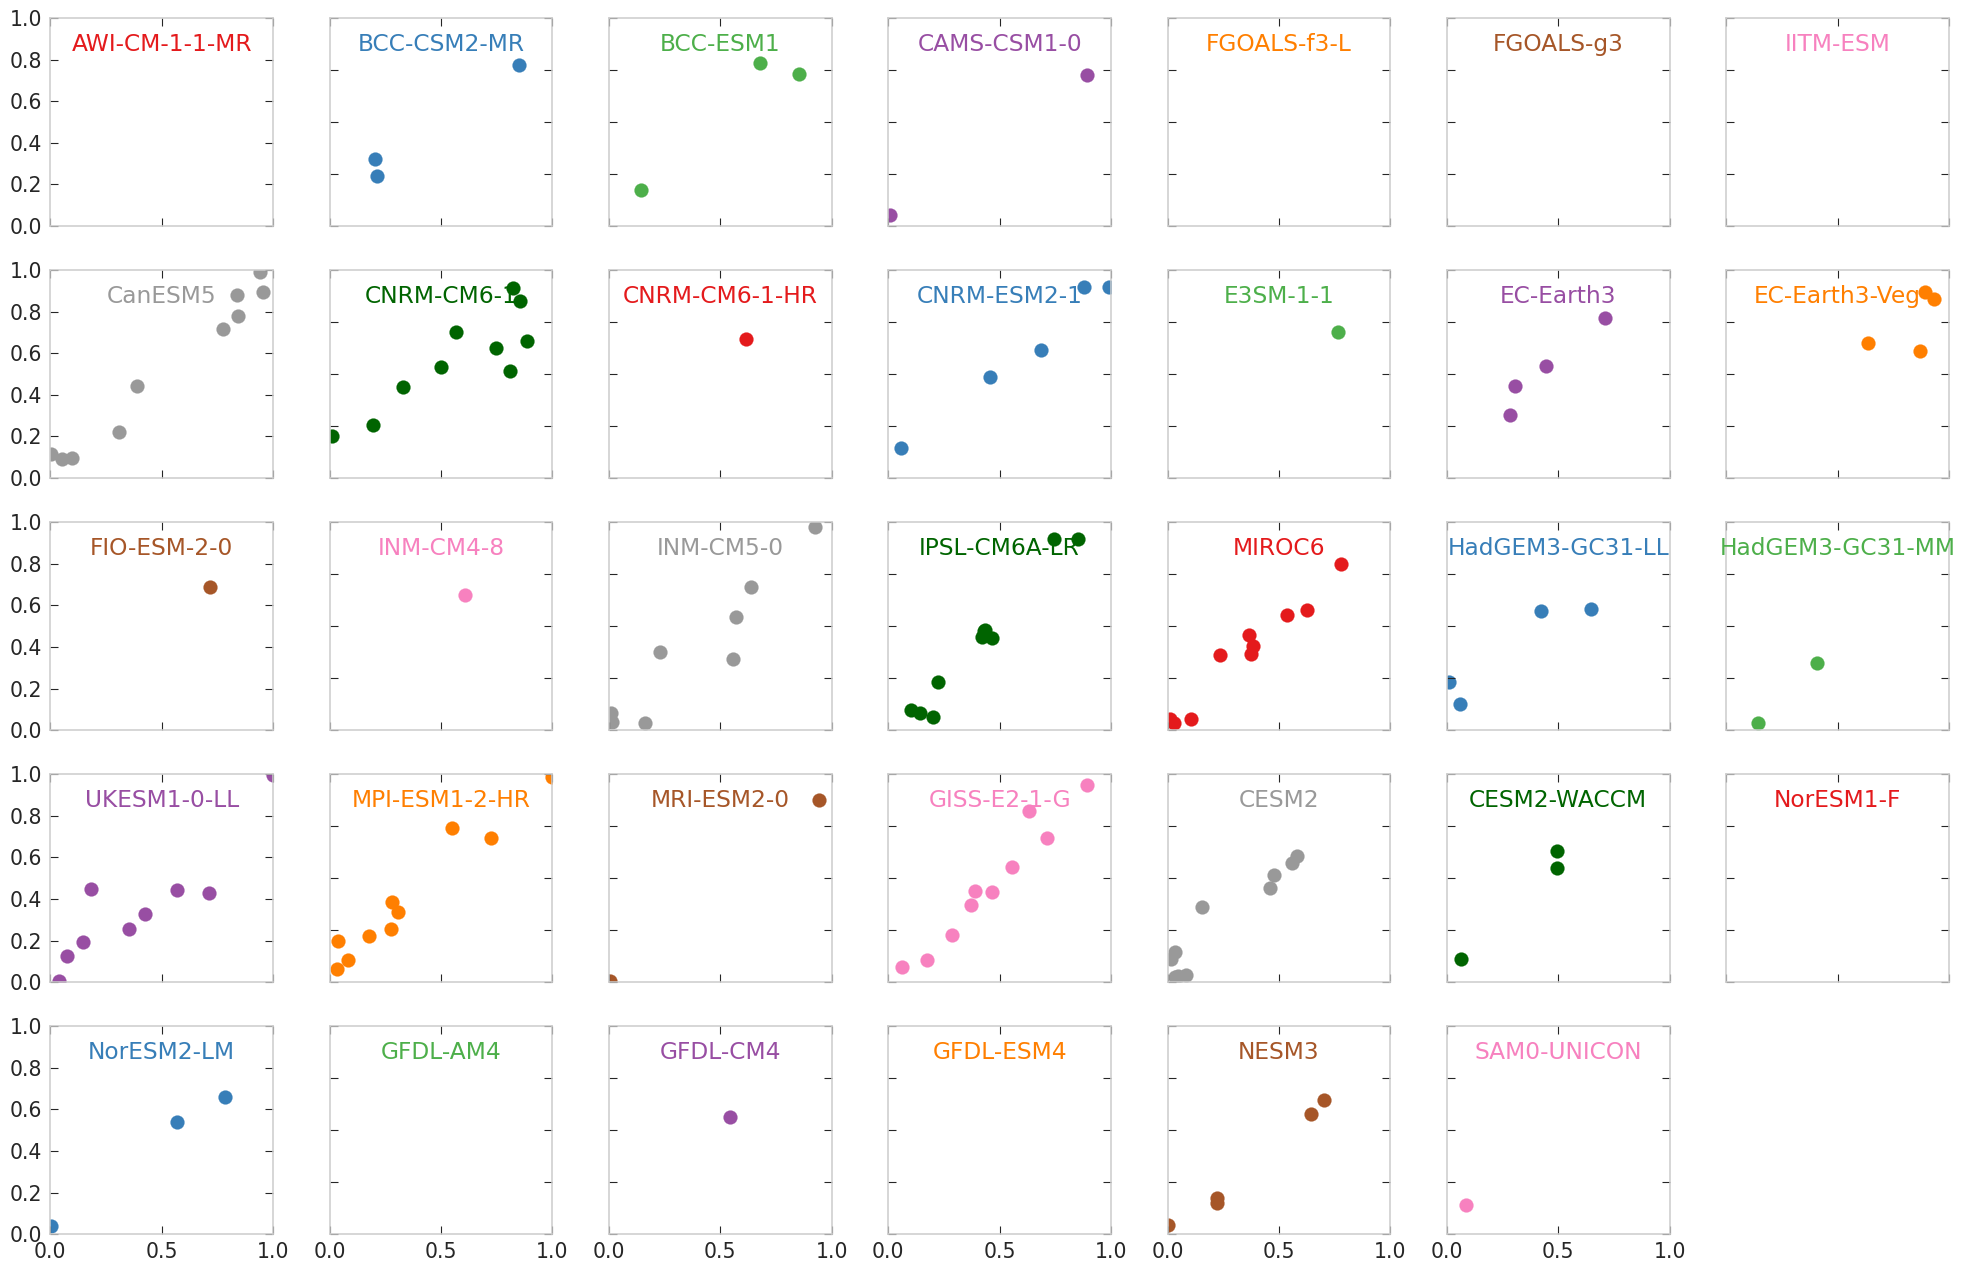

In [96]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/19) for i in np.arange(0,20)]+[cmap(i/20) for i in np.arange(0,20)]
color_list = np.tile(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#b15928'],4)
color_list = np.tile(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#f781bf','#999999','darkgreen'],10)
markers = ['x','o','h','s']

fig, axs = plt.subplots(5,7,figsize = (20,13),facecolor='white')
for i, ax in enumerate(axs.flatten()):
    if i<=33:
        mod = models[i]
        marker = markers[i%4]
        marker='o'
        col = color_list[i]
        ax.scatter(ppvs[0][i],tpvs[0][i],color=col,label=mod,marker=marker,s=100)
        ax.set_ylim(0,1)
        ax.set_xlim(0,1)
#         ax.hlines(0,-10,10,color='k',alpha=0.2)
#         ax.vlines(0,-10,10,color='k',alpha=0.2)
        ax.set_title(mod,color=col,y=0.8)
    if not ((i==0) or (i==7) or (i==14) or (i==21) or (i==28)):
        ax.tick_params(axis='y', which='both',labelleft=False, labelsize=fontsize)
    if not (i>=28): 
        ax.tick_params(axis='x', which='both',bottom=True,top=True,labelbottom=False, labelsize=fontsize)
    if i==34:
        ax.axis('off')
            
# ax.ylabel('AMOC strength trend at 26.5N [Sv/Century]')
# ax.xlabel('AMOC index trend [K/Century]')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
# fig.supxlabel('Trend of AMOC SST Index [K/Century]',fontsize=25)
# fig.supylabel('Trend of AMOC Strength at 26.5N [Sv/Century]',fontsize=25,x=0.01)
fig.tight_layout()
# ax.legend(bbox_to_anchor=(-1.3, -0.1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=5)
plt.show()

In [97]:
yrs = strn26.year.values
strn26_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn26.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn26_trend[imod,iens]=slope*100 # trend of Sv/century
index_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        idx = np.nan_to_num(index.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, idx)
        index_trend[imod,iens]=slope*100 # trend of Sv/century
strn35_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn35.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn35_trend[imod,iens]=slope*100 # trend of Sv/century

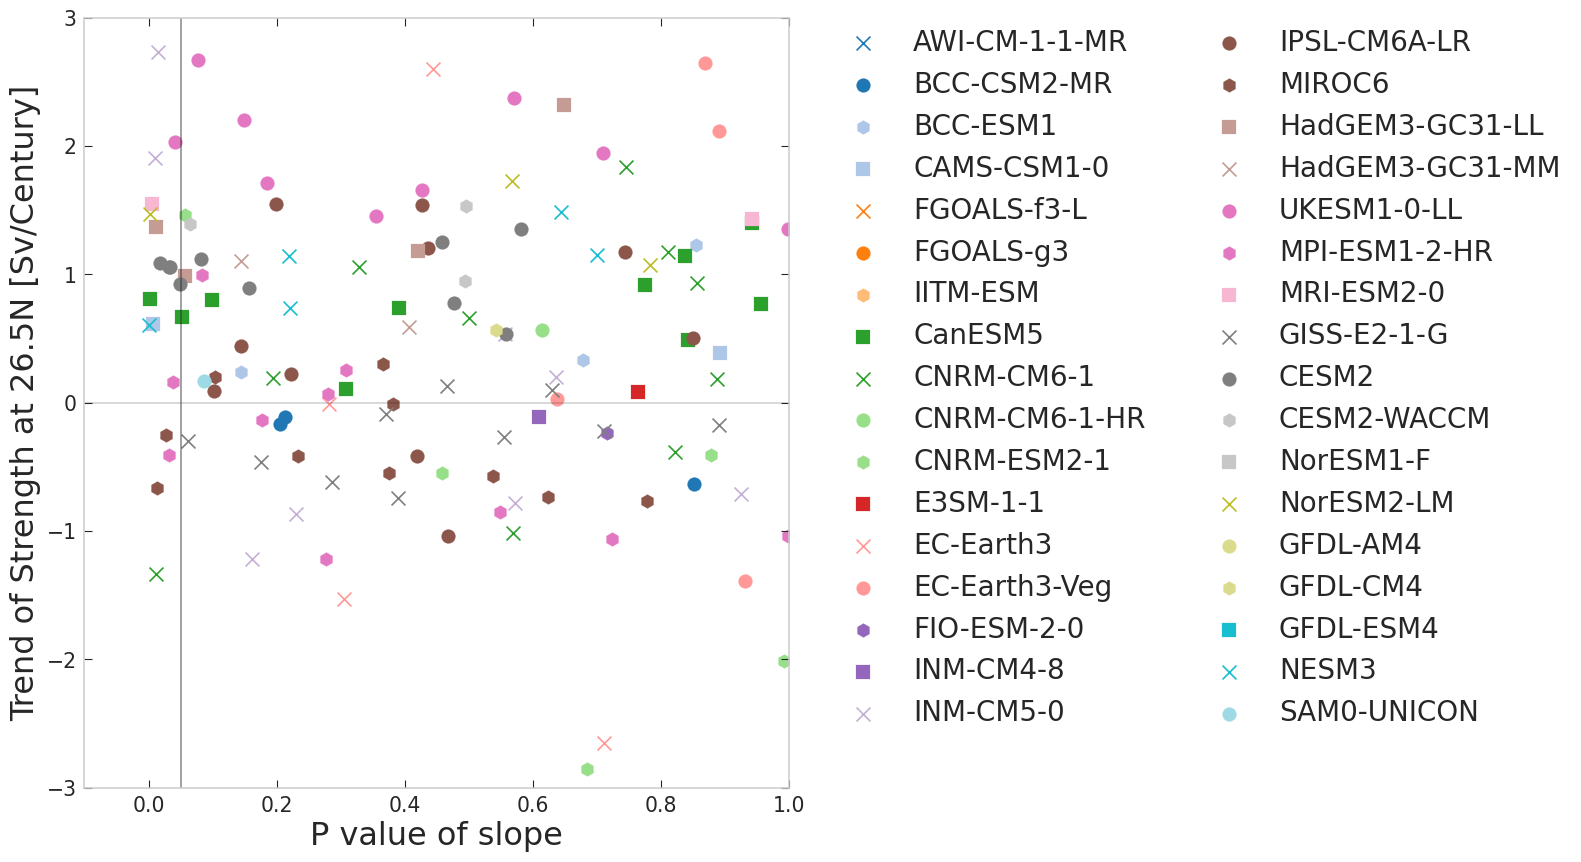

In [98]:
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['x','o','h','s']

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
for i, mod in enumerate(models):
    marker = markers[i%4]
    col = color_list[i]
    plt.scatter(ppvs[0][i],strn26_trend[i],color=col,label=mod,marker=marker,s=100)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=2)
ax.hlines(0,-0.1,1,color='k',alpha=0.2)
ax.vlines(0.05,-4,4,color='k',alpha=0.5)
ax.set_xlim(-0.1,1)
ax.set_ylim(-3,3)
ax.set_ylabel('Trend of Strength at 26.5N [Sv/Century]')
ax.set_xlabel('P value of slope')
plt.show()

In [99]:
model = 'CESM2'
iens = 2
indx = 'strn26'

data = ds.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
ctau = cmip_taus.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
cp = cmip_ps.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

In [100]:
st.percentileofscore(data.taus.dropna(dim='surrogates').values,ctau.values)

96.51000963494272

In [101]:
np.percentile(data.taus.dropna(dim='surrogates').values,95)

0.6019417475728156

In [102]:
ctau

<xarray.DataArray 'taus' ()>
array(0.648718)
Coordinates:
    indices           <U6 'strn26'
    models            <U5 'CESM2'
    ensemble_members  <U8 'r3i1p1f1'

limit_output extension: Maximum message size of 10000 exceeded with 11636 characters

(array([ 152.,  594.,  959., 1411., 1483., 1423., 1390., 1106.,  647.,
         176.]),
 array([-0.91971621, -0.739059  , -0.55840179, -0.37774459, -0.19708738,
        -0.01643017,  0.16422704,  0.34488424,  0.52554145,  0.70619866,
         0.88685586]),
 <BarContainer object of 10 artists>)

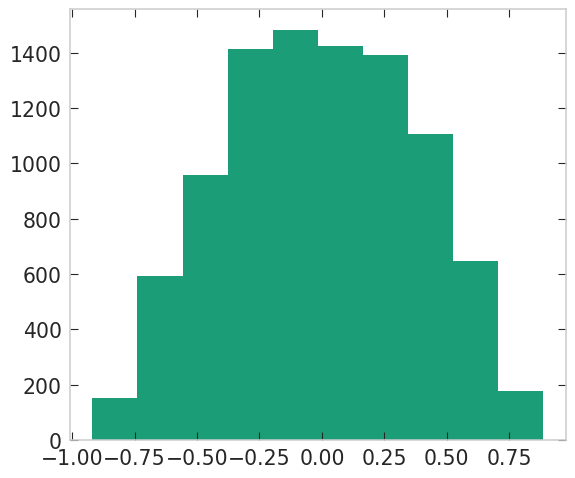

In [103]:
plt.hist(data.taus)

In [104]:
levels = [0] + list(np.logspace(np.log10(0.05),0,9))
colorss = ['white','#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
# colorss = ['white','#ffffe5','#fff7bc','#fee391','#fec44f','#fe9929','#ec7014','#cc4c02','#993404','#662506']

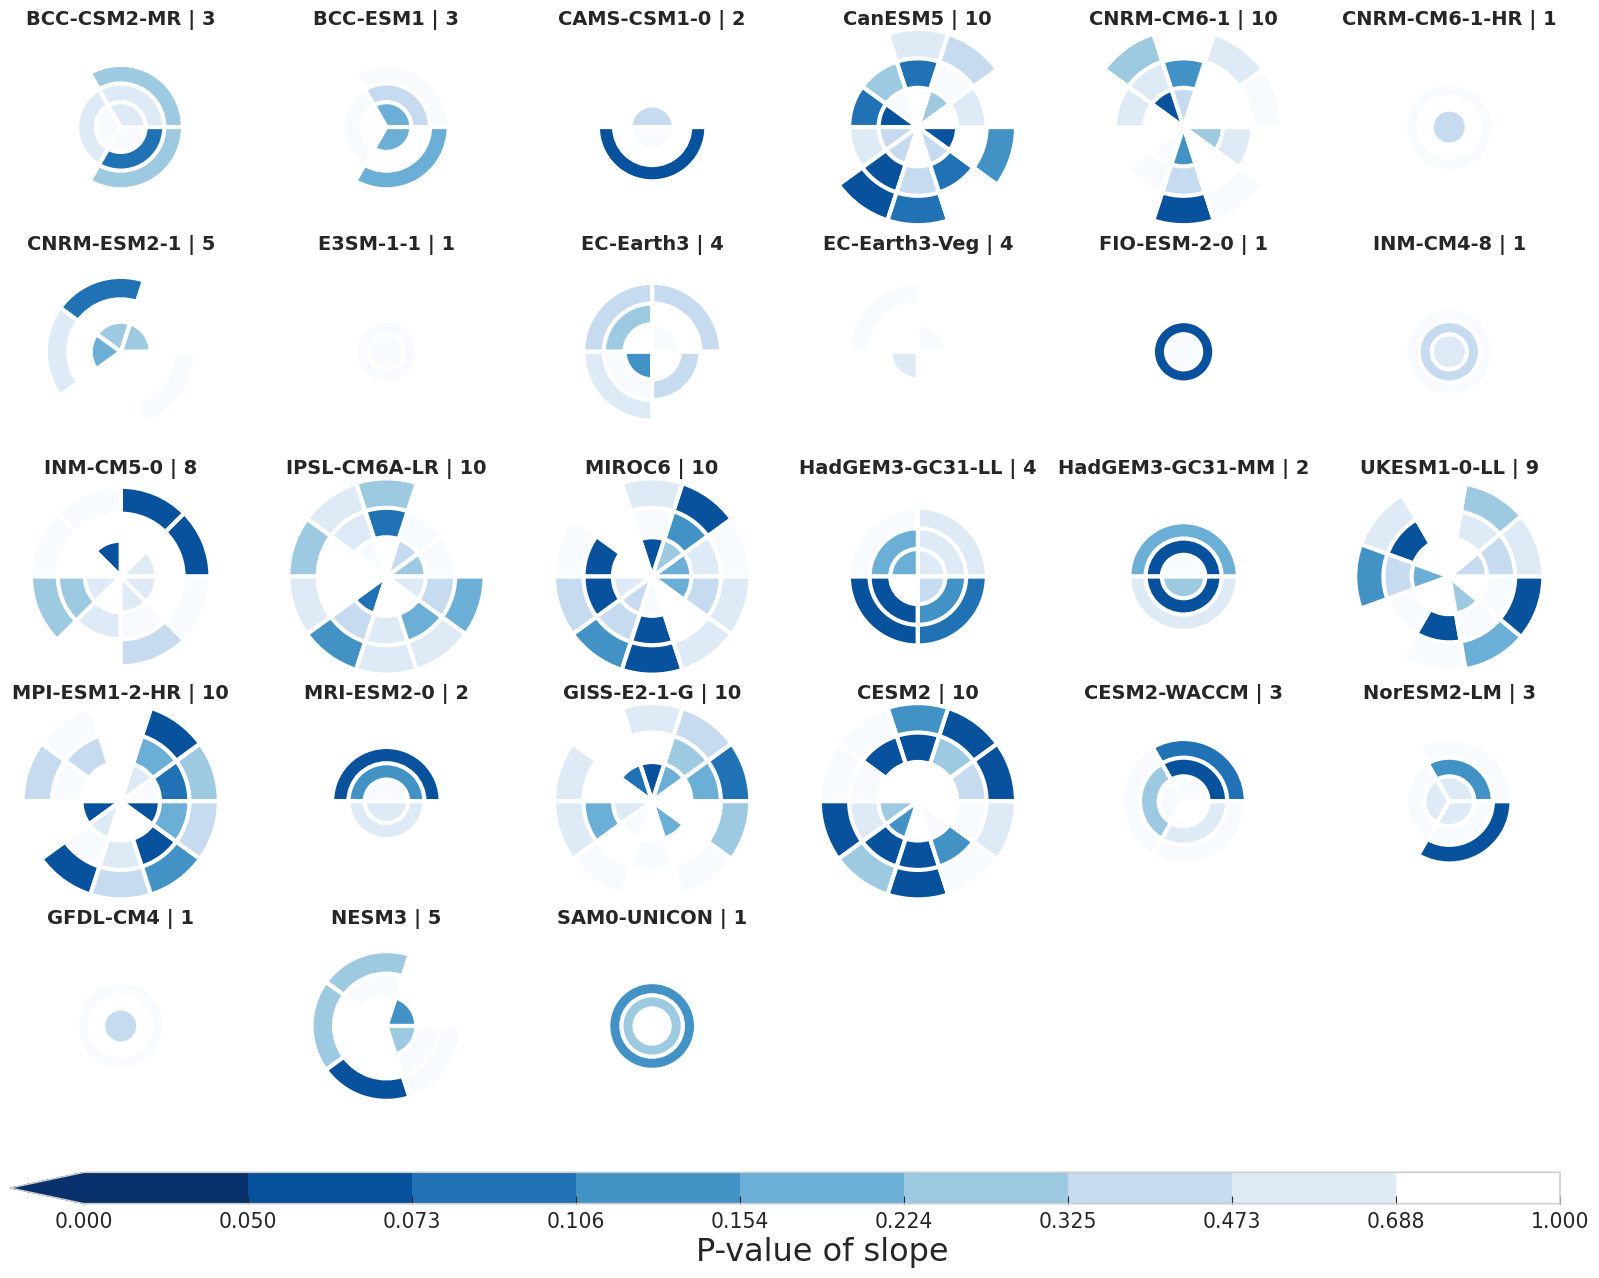

In [105]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(nrows=6, ncols=6,height_ratios=(1,1,1,1,1,0.2))
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))


    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        rads = [1,0.7,0.4]
        
        for i in range(3):
            data = ppvs[i][im][idc]
            slices = np.full(len(data),1)
            cols = np.full(len(data),'lightgrey')
            for il, level in enumerate(levels[::-1]):
                idc2 = np.where(data<=level)
                cols[idc2]=colorss[il]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
cax = fig.add_subplot(gs[5,:])
cmap = mpl.colors.ListedColormap(colorss[::-1])
norm = mpl.colors.BoundaryNorm(levels, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levels,boundaries=levels,norm=norm,
                            orientation='horizontal',label='P-value of slope',extend='min')

fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

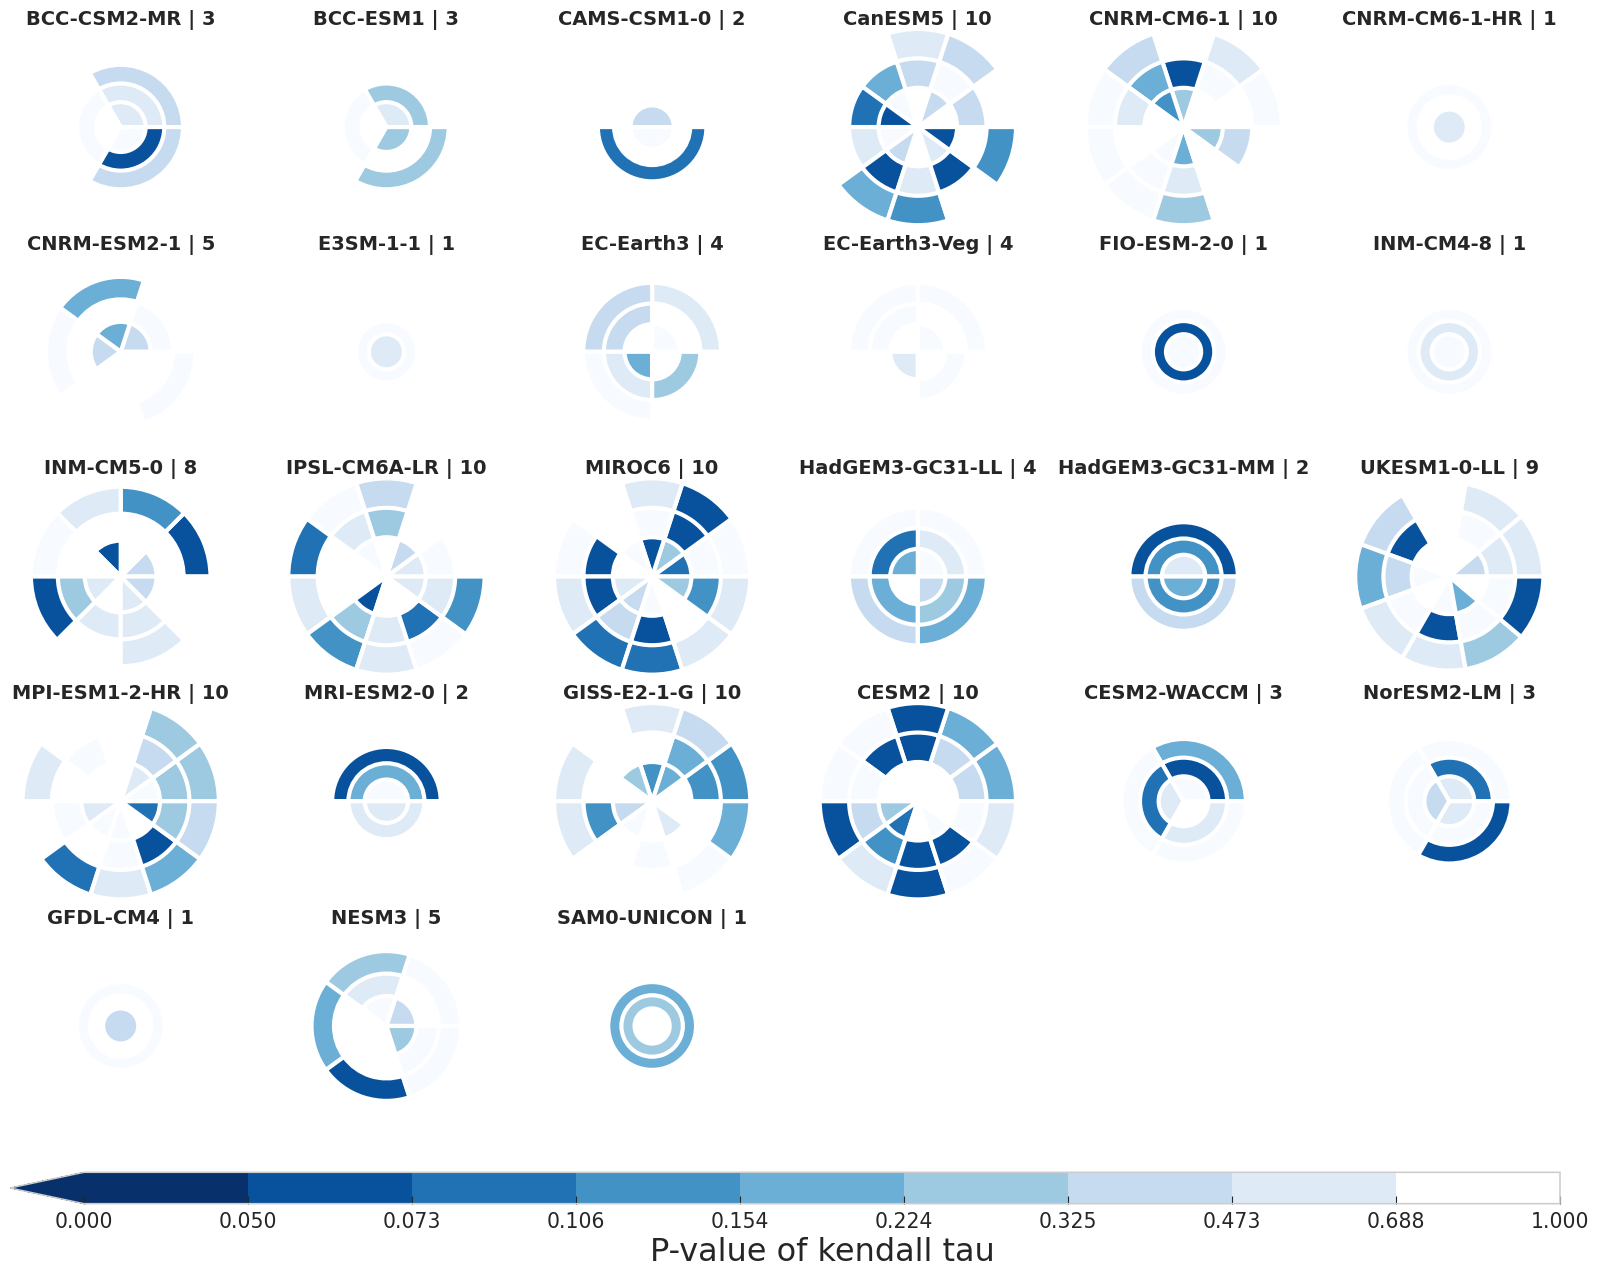

In [106]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(nrows=6, ncols=6,height_ratios=(1,1,1,1,1,0.2))
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))


    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        rads = [1,0.7,0.4]
        
        for i in range(3):
            data = tpvs[i][im][idc]
            slices = np.full(len(data),1)
            cols = np.full(len(data),'lightgrey')
            for il, level in enumerate(levels[::-1]):
                idc2 = np.where(data<=level)
                cols[idc2]=colorss[il]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
cax = fig.add_subplot(gs[5,:])
cmap = mpl.colors.ListedColormap(colorss[::-1])
norm = mpl.colors.BoundaryNorm(levels, cmap.N)
mpl.colorbar.ColorbarBase(cax, cmap=cmap,ticks=levels,boundaries=levels,norm=norm,
                            orientation='horizontal',label='P-value of kendall tau',extend='min')

fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

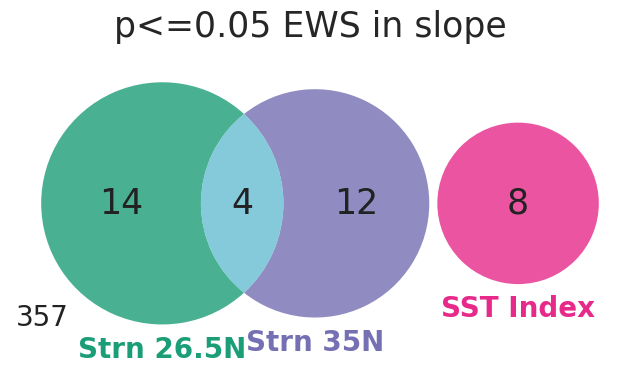

In [107]:
from matplotlib_venn import venn3, venn3_circles
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
subsets = (14, 12, 4, 8, 0, 0, 0)
cols = ['C0','C2','C3']
out = venn3(subsets = subsets, set_labels = ('Strn 26.5N', 'Strn 35N', 'SST Index'), alpha = 0.8,set_colors=['C0','C2','C3'])
# venn3_circles(subsets = subsets)
for i, text in enumerate(out.set_labels):
    text.set_fontsize(20)
    text.set_fontweight('bold')
    text.set_color(cols[i])
for text in out.subset_labels:
    try:
        text.set_fontsize(25)
        text.set_color('k')
    except:
        continue
ax.text(0.01,0.1,357,transform=ax.transAxes,ma='left',color='k',fontsize=20)
fig.patch.set_facecolor("white")
fig.suptitle('p<=0.05 EWS in slope',fontsize=25)
plt.show()

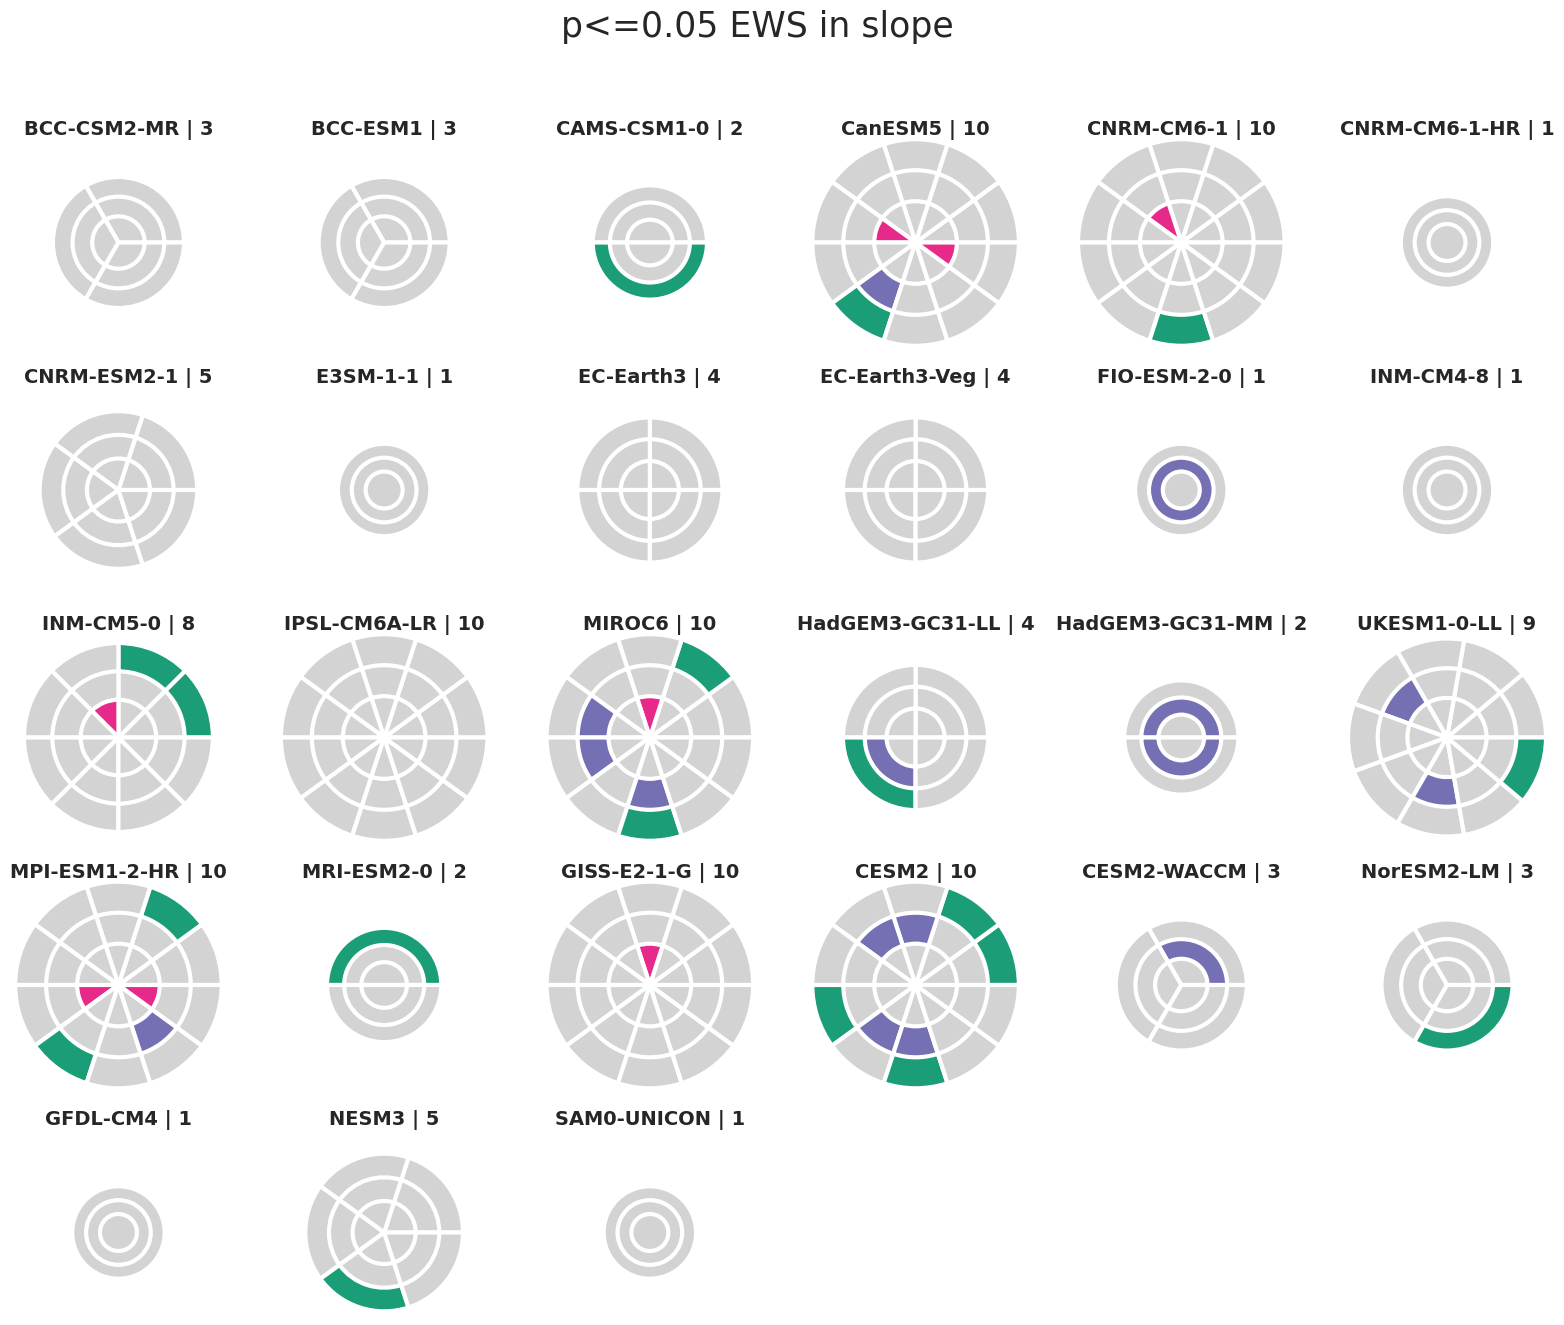

In [108]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(5, 6)
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(cmip_ps.sel(indices='strn26').sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(cmip_ps.sel(indices='strn26').sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        colorss = ['C0','C2','C3']
        rads = [1,0.7,0.4]
        
        for i in range(3):
            data = ppvs[i][im][idc]
            slices = np.full(len(data),1)
            idc2 = np.where(data<=0.05)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.suptitle('p<=0.05 EWS in slope',fontsize=25)
fig.patch.set_facecolor("white")
plt.show()

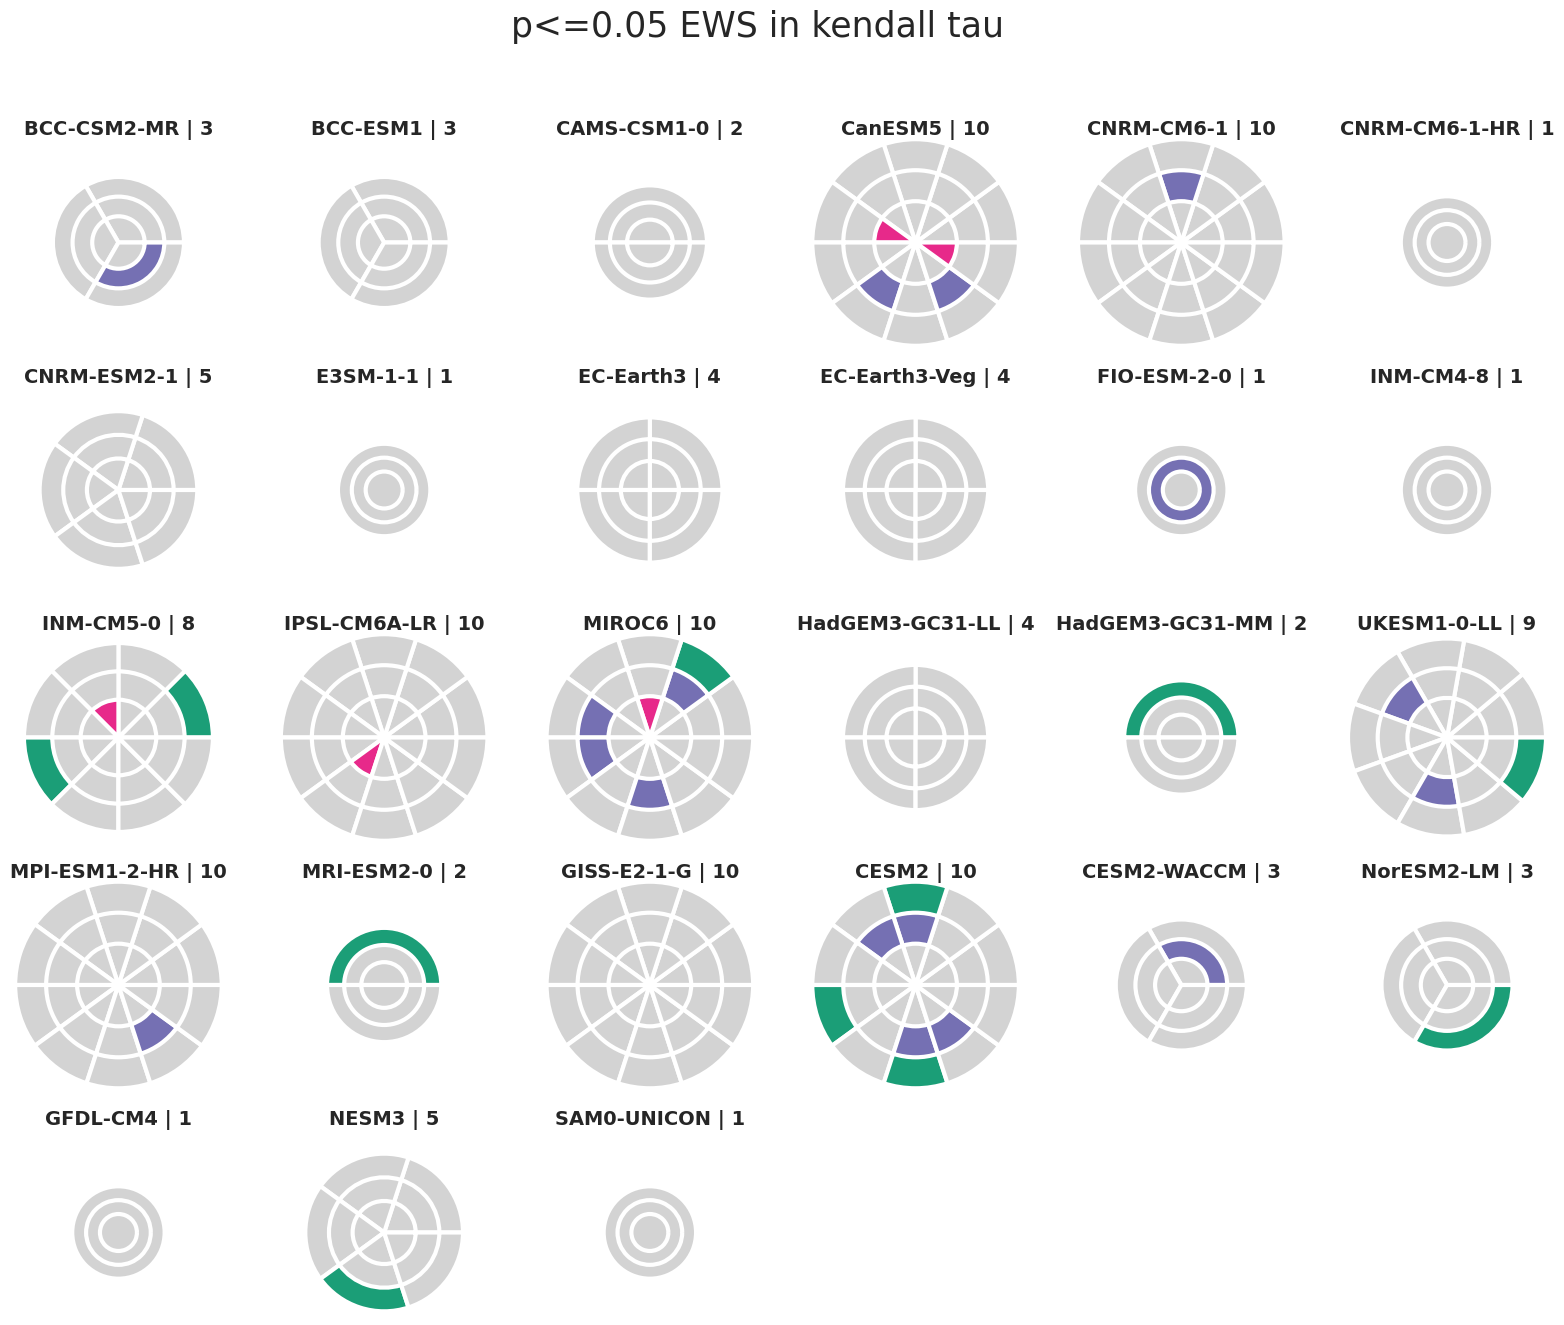

In [109]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(5, 6)
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(cmip_taus.sel(indices='strn26').sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        colorss = ['C0','C2','C3']
        rads = [1,0.7,0.4]
        
        for i in range(3):
            data = tpvs[i][im][idc]
            slices = np.full(len(data),1)
            idc2 = np.where(data<=0.05)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.suptitle('p<=0.05 EWS in kendall tau',fontsize=25)
fig.patch.set_facecolor("white")
plt.show()

In [110]:
# autocorrelation

In [111]:
def detrend(data,gedge=5):
    amoc = np.nan_to_num(data)
    amoc_low = gaussian_filter1d(amoc, 10)
    amc = (amoc - amoc_low)[gedge:-gedge]
    ts = amc - amc.mean()
    return ts

In [112]:
def get(data):
    return data.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

In [113]:
def kde_plot(ax,xs,data,col='C0',lbl='',linestyle='-',norm=False):
    data = data[~np.isnan(data)]
    if data.sum()==0:
        ax.plot(xs,np.full_like(xs,0))
    else:
        density = gaussian_kde(data)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ys = density(xs)
        if norm:
            ax.plot(xs,ys/ys.max(),color=col,label=lbl,lw=2,linestyle=linestyle)
        else:
            ax.plot(xs,ys,color=col,label=lbl,lw=2,linestyle=linestyle)

In [114]:
def get_as(data):
    ass = []
    for i in range(len(data)):
        ass.append(sm.tsa.acf(data[i], nlags=1)[1])
    return np.array(ass)

In [115]:
# data = xr.open_mfdataset('/p/tmp/mayayami/AR6/CMIP6_surr_autc*_w70.nc',concat_dim='surrogates',combine='nested')
# data.to_netcdf('/p/tmp/mayayami/AR6/CMIP6_surr_autc_w70.nc')
data = xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_autc_w50.nc').a
data30 = xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_autc_w30.nc').a
data70 = xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_autc_w70.nc').a
amc_data = xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_amoc_surr_autc.nc').a

In [116]:
pdata = xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_autc_postEWS_w50.nc').a
pdata30 = xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_autc_postEWS_w30.nc').a
pdata70 = xr.open_dataset('/p/tmp/mayayami/AR6/CMIP6_surr_autc_postEWS_w70.nc').a

In [117]:
cmip_lams50 =  xr.open_dataset('new_EWS/CMIP6_lam_pvs_w50.nc').lambdas
cmip_lams30 =  xr.open_dataset('new_EWS/CMIP6_lam_pvs_w30.nc').lambdas
cmip_lams70 =  xr.open_dataset('new_EWS/CMIP6_lam_pvs_w70.nc').lambdas

In [118]:
model = 'NESM3'
# model = 'EC-Earth3'
# model = 'IPSL-CM6A-LR'
iens = 0
indx = 'strn26'

dt = data.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
dt30 = data30.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
dt70 = data70.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
amc_dt = amc_data.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

calam30 = sm.tsa.acf(cmip_lams30.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)[15:-15],nlags=1)[1]
calam50 = sm.tsa.acf(cmip_lams50.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)[25:-25],nlags=1)[1]
calam70 = sm.tsa.acf(cmip_lams70.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)[35:-35],nlags=1)[1]

pdt = pdata.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
pdt30 = pdata30.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
pdt70 = pdata70.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)

amoc = xr.open_dataset('CMIP6_amoc2.nc').amoc
amc = amoc.sel(models=model).isel(ensemble_members=iens).sel(indices=indx)
ts = detrend(amc.values)
caamc = sm.tsa.acf(ts,nlags=1)[1]

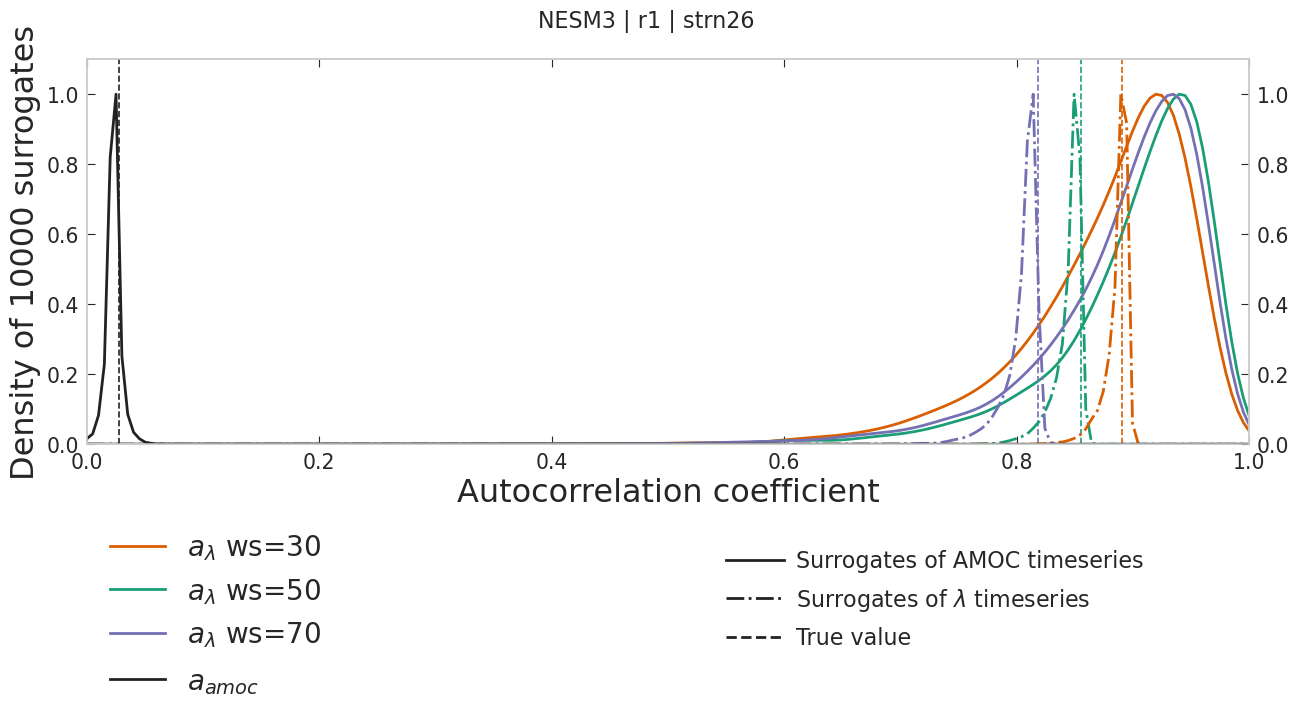

In [119]:

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
xs = np.linspace(0,1,200)
kde_plot(ax,xs,dt30,col='C1',lbl='$a_\lambda$ ws=30',norm=True)
kde_plot(ax,xs,dt,col='C0',lbl='$a_\lambda$ ws=50',norm=True)
kde_plot(ax,xs,dt70,col='C2',lbl='$a_\lambda$ ws=70',norm=True)
ax.vlines(calam30,0,8,color='C1',linestyle='--')
ax.vlines(calam50,0,8,color='C0',linestyle='--')
ax.vlines(calam70,0,8,color='C2',linestyle='--')

kde_plot(ax,xs,pdt,col='C0',linestyle='-.',norm=True)
kde_plot(ax,xs,pdt30,col='C1',linestyle='-.',norm=True)
kde_plot(ax,xs,pdt70,col='C2',linestyle='-.',norm=True)

ax.set_ylim(0,1.1)
ax2= ax.twinx()
kde_plot(ax2,xs,amc_dt,col='k',lbl='$a_{amoc}$',norm=True)
ax2.vlines(caamc,0,100,color='k',linestyle='--')
ax2.set_ylim(0,1.1)
ax.set_xlim(0,1)
ax.set_ylabel('Density of 10000 surrogates')
ax.set_xlabel('Autocorrelation coefficient')
ax.legend(bbox_to_anchor=(0.01, -0.2), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=1)
ax2.legend(bbox_to_anchor=(0.01, -0.55), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=1)
fig.suptitle('{} | r{} | {} '.format(model,iens+1,indx))
ax.plot([.55,.6],[-0.3,-0.3],transform=ax.transAxes,color='k',clip_on=False,linewidth=2)   
ax.text(.61,-0.32,'Surrogates of AMOC timeseries',transform=ax.transAxes,fontsize=fontsize)
ax.plot([.55,.6],[-0.4,-0.4],transform=ax.transAxes,color='k',clip_on=False,linewidth=2,linestyle='-.')   
ax.text(.61,-0.42,'Surrogates of $\lambda$ timeseries',transform=ax.transAxes,fontsize=fontsize)
ax.plot([.55,.6],[-0.5,-0.5],transform=ax.transAxes,color='k',clip_on=False,linewidth=2,linestyle='--')   
ax.text(.61,-0.52,'True value',transform=ax.transAxes,fontsize=fontsize)
plt.show()

# create a files

In [120]:
data = xr.open_dataset('CMIP6_amoc2.nc').amoc

dim1, dim2, dim3, dim4 = data.shape[0],data.shape[1],data.shape[2],data.shape[3]
ass = np.full((dim1, dim2, dim3),np.nan)
for i in np.arange(0,dim1):
    for j in np.arange(0,dim2):
        for k in np.arange(0,dim3):
            amc = data[i,j,k]
            ts = detrend(amc.values)
            ass[i,j,k] = sm.tsa.acf(ts,nlags=1)[1]

/p/tmp/mayayami/mayaenv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:675: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


In [121]:
models = strn26.models.values
ensembs = strn26.ensemble_members.values
indices = ['strn26','strn35','index']
a_array = xr.Dataset(
                data_vars = dict(a=(['indices','models','ensemble_members'],ass)),
                coords = dict(
                        indices      = xr.DataArray(indices, dims="indices", coords=dict(indices=("indices", indices))),
                        models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
                        ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
            )
a_array.to_netcdf('amoc_autc.nc')